# Load the libraries and the image we are going to use

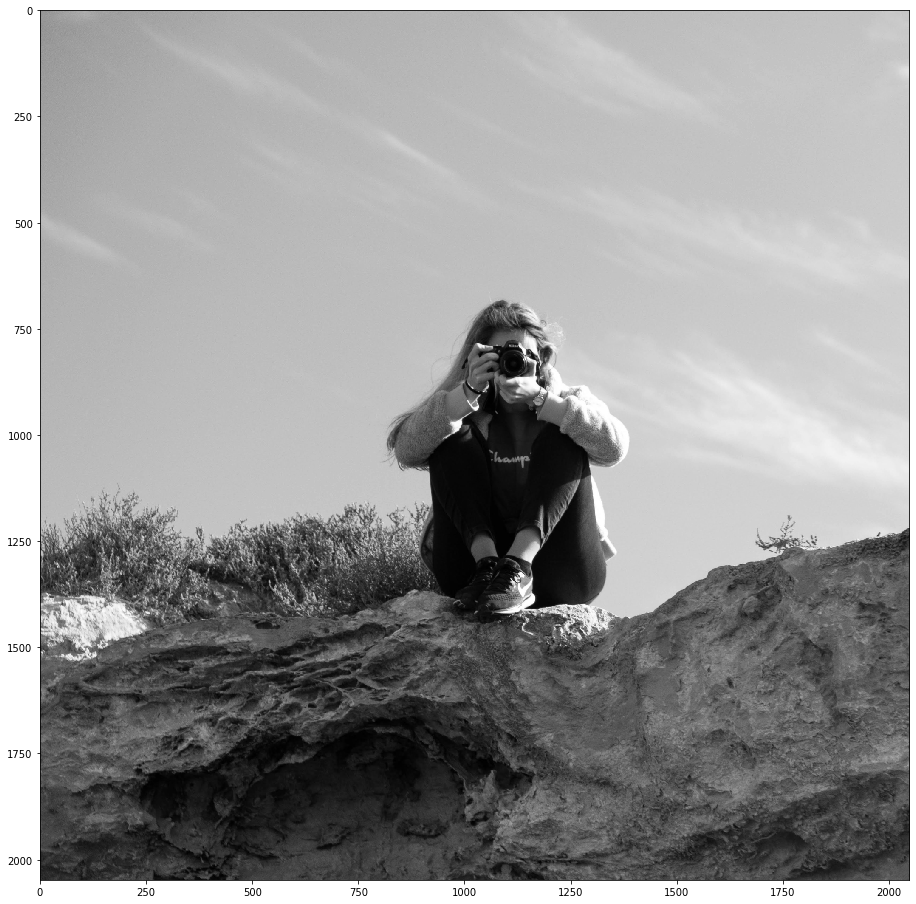

In [1]:
import cv2 
import numpy as np 
import random
from twoDDWT import *


%matplotlib inline 
from matplotlib import pyplot as plt
import pylab 
pylab.rcParams['figure.figsize'] = (20, 16) 

input_image=cv2.imread('data/Photographe.jpg',cv2.IMREAD_GRAYSCALE)

img = cv2.resize(input_image, (2048,2048), interpolation = cv2.INTER_AREA)  #So we have a size of 2^j for the transform.

plt.imshow(img,cmap='gray')

In [2]:
def mse(imageA, imageB):
    err = np.sum(np.sqrt((imageA.astype("float") - imageB.astype("float")) ** 2))
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

# We are going to add different noises at the different level

## Add different levels of Gausian Noise

0.0
9.383784532546997
18.957965850830078
27.89564871788025
35.968485593795776
43.3004686832428
49.959070920944214
55.989479541778564
61.38669228553772


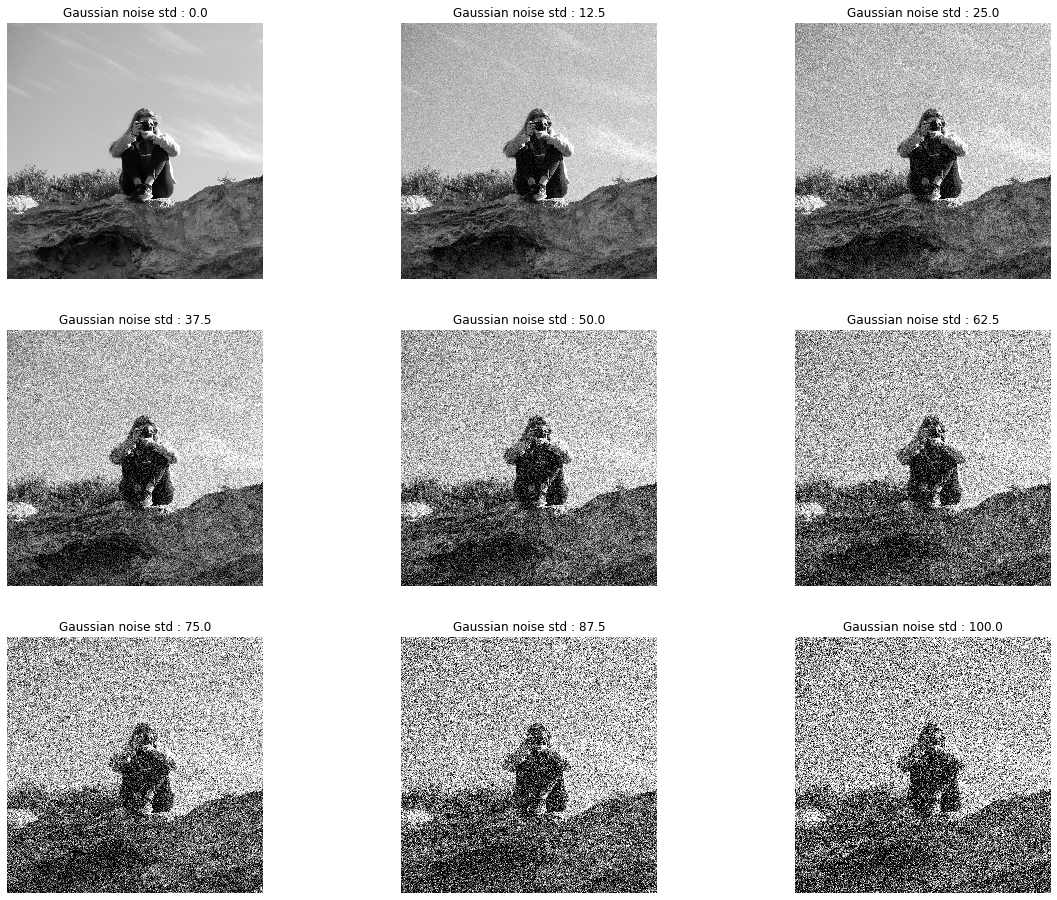

In [3]:
mean = 0.0  
Std = np.linspace(0,100,9)
Noisy_gauss = []
for std in Std:
    noisy_img = img + np.random.normal(mean, std, img.shape).astype(int)
    noisy_clip = np.clip(noisy_img, 0, 255)
    Noisy_gauss.append(noisy_clip)
    print(mse(noisy_clip,img))

pylab.rcParams['figure.figsize'] = (20, 16) 
for i in range(len(Std)):
    show = Noisy_gauss[i]
    plt.subplot(3,3,i+1)
    plt.title("Gaussian noise std : "+str(Std[i]))
    plt.axis('off')
    plt.imshow(show,cmap='gray')
plt.savefig("data/Gaussian noise")

# Let's see the effects of differents filters


## Gaussian blurr

1.681206464767456
3.5189499855041504
4.753331422805786
5.875993490219116
7.229536056518555
9.162943840026855
11.605323791503906
14.324544668197632
17.115105390548706


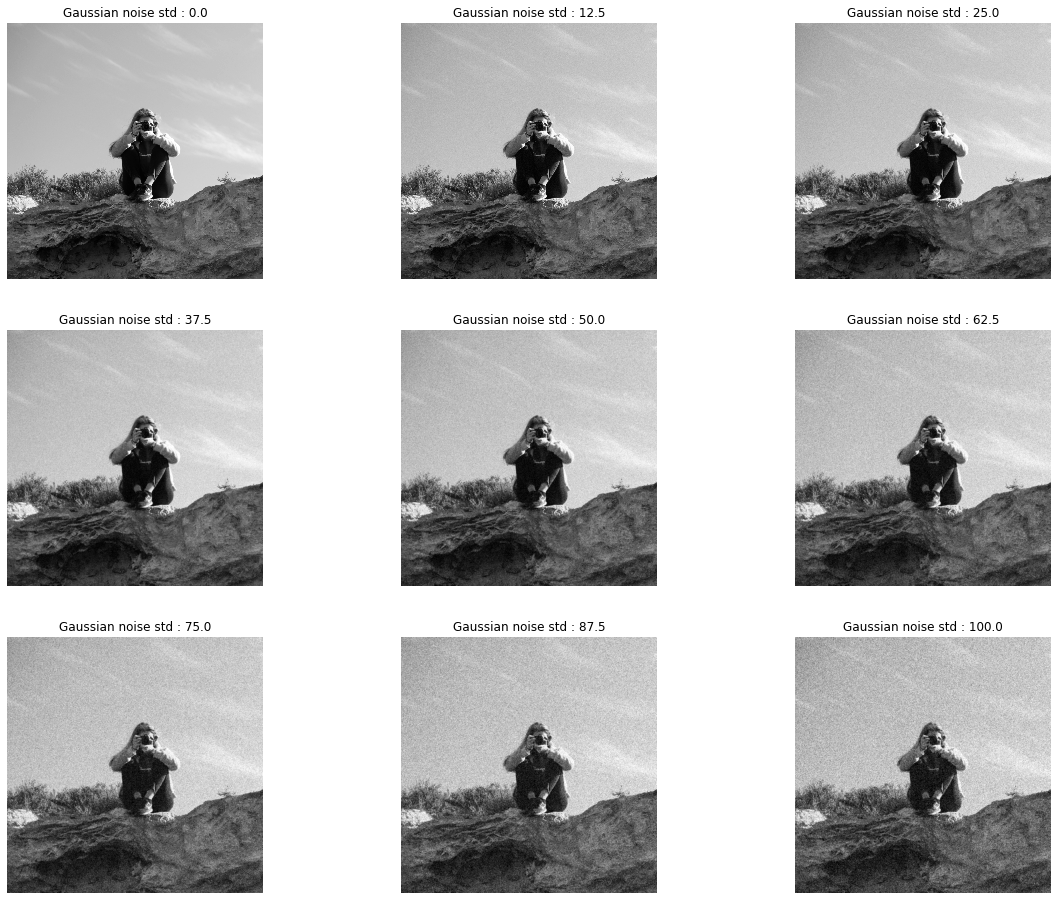

In [4]:
Gaussian_gauss = []

for i in range(len(Std)):
    mini = np.inf
    for sig in range(1,20):
        gaussian_ = np.uint8(Noisy_gauss[i])                      #Problem of unit 
        blurred_ = cv2.GaussianBlur(gaussian_,(0,0),sigmaX = sig)
        if mse(blurred_,img)< mini:
            mini = mse(blurred_,img)
            best = blurred_
    Gaussian_gauss.append(best)
    print(mini)

    
pylab.rcParams['figure.figsize'] = (20, 16) 
for i in range(len(Std)):
    show = Gaussian_gauss[i]
    plt.subplot(3,3,i+1)
    plt.title("Gaussian noise std : "+str(Std[i]))
    plt.axis('off')
    plt.imshow(show,cmap='gray')
plt.savefig("data/Gaussian noise filtered by Gaussian")

## Discrete Wavelet Transform

In [5]:
def thresh_detail(transform_input,scale,thresh):
    transform = np.copy(transform_input)
    (l,c) = np.shape(transform)
    for i in range(scale):
        l = l//2
        c = c//2
            
    approx = np.copy(transform[:l,:c])
    transform[np.abs(transform)<thresh] = 0
    transform[:l,:c] = approx
    return transform

def max_detail(transform_input,scale):
    transform = np.copy(transform_input)
    (l,c) = np.shape(transform)
    for i in range(scale):
        l = l//2
        c = c//2
            
    transform[:l,:c] = np.zeros((l,c))
    return np.abs(transform).max()

current image:  0
Minimum for image  0  :  0.0 

current image:  1
        New mini found:  9.370681097730994
        New mini found:  9.302641678601503
        New mini found:  9.092206411063671
        New mini found:  8.5193833373487
        New mini found:  7.255576308816671
        New mini found:  5.095429863780737
        New mini found:  3.7147969976067543
Minimum for image  1  :  3.7147969976067543 

current image:  2
        New mini found:  18.956538382917643
        New mini found:  18.936902141198516
        New mini found:  18.87024201825261
        New mini found:  18.666732128709555
        New mini found:  18.105894995853305
        New mini found:  16.645557835698128
        New mini found:  13.466203778982162
        New mini found:  8.265767227858305
        New mini found:  5.193146824836731
Minimum for image  2  :  5.193146824836731 

current image:  3
        New mini found:  27.89557116664946
        New mini found:  27.885707546025515
        New mini found:  2

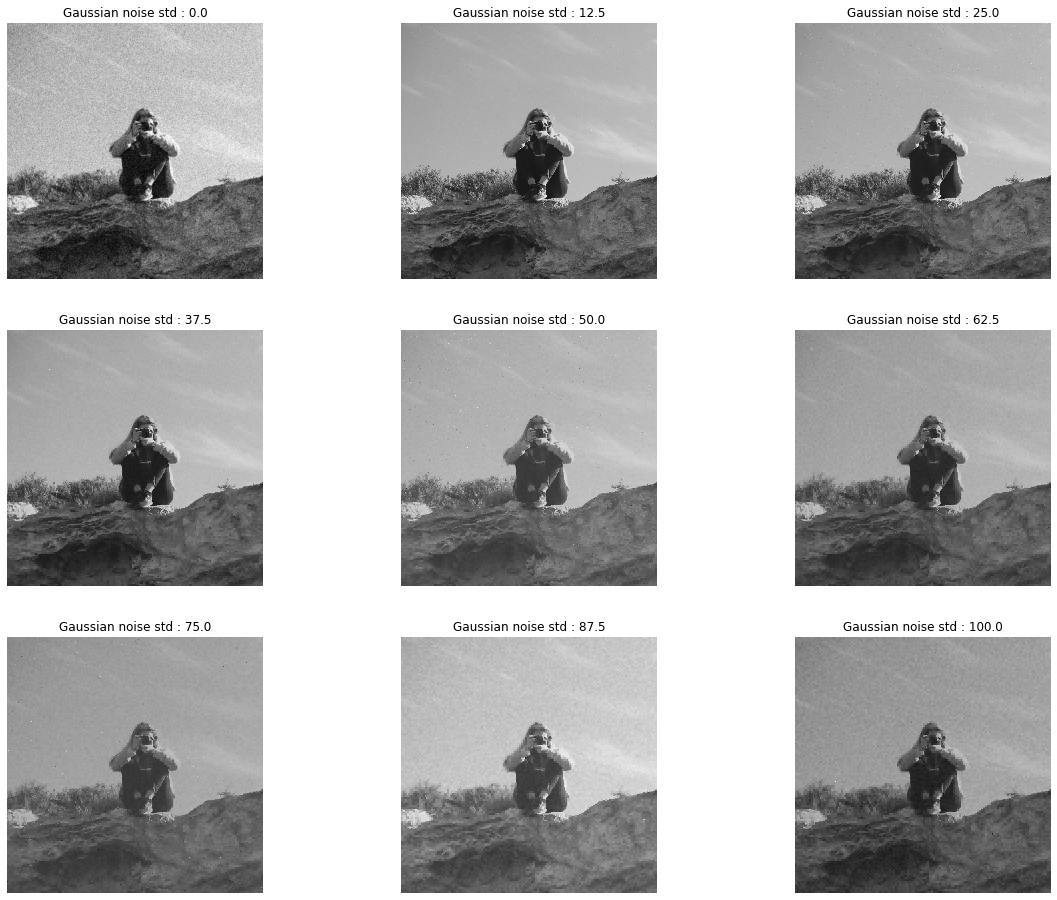

In [6]:
Gaussian_DWT = []


for i in range(len(Std)):
    print("current image: ",i)
    gaussian_ = Noisy_gauss[i]
    gaussian_ = gaussian_.astype('float64')
    mini = mse(gaussian_,img)
    scale = 4
    error_interm = []
    transform = twoDDWT(gaussian_,scale)
    maxi = max_detail(transform,scale)
    for thresh in np.logspace(0,3,20):    #This interval results from a previous bigger search
        if thresh > maxi:
            break;
        transform_tresh = thresh_detail(transform,scale,thresh)
        reconstruct = inverse_twoDDWT(transform_tresh,scale)
        error = mse(reconstruct,img)
        if error < mini:
            mini = error
            best = reconstruct
            print('        New mini found: ',mini)
        if mini<1:
            break;
    Gaussian_DWT.append(best)
    print("Minimum for image ",i," : ",mini,"\n")
    
    
pylab.rcParams['figure.figsize'] = (20, 16) 
for i in range(len(Std)):
    show = Gaussian_DWT[i]
    plt.subplot(3,3,i+1)
    plt.title("Gaussian noise std : "+str(Std[i]))
    plt.axis('off')
    plt.imshow(show,cmap='gray')
plt.savefig("data/Gaussian noise filtered DWT")

# Dohono Method

In [9]:
def thresh(transform_input,scale, typ = "hard"):
    transform = np.copy(transform_input)
    (l,c) = np.shape(transform)
    for i in range(scale):
        diagonal = np.copy(transform[l//2:l,c//2:c])   #diagonal
        vertical = np.copy(transform[:l//2,c//2:c])    #vertical
        horizontal = np.copy(transform[l//2:l,:c//2])  #horizontal

        
        sigma_diago = np.median(np.abs(diagonal))/0.6745 #Donoho paper
        sigma_verti = np.median(np.abs(vertical))/0.6745
        sigma_hori = np.median(np.abs(horizontal))/0.6745 
        
        length = (l//2) * (c//2)  
        thresh_diago = sigma_diago * np.sqrt(2*np.log10(length))
        thresh_verti = sigma_verti * np.sqrt(2*np.log10(length))
        thresh_hori = sigma_hori * np.sqrt(2*np.log10(length))
        
        
        diagonal[np.abs(diagonal)<thresh_diago] = 0
        vertical[np.abs(vertical)<thresh_verti] = 0
        horizontal[np.abs(horizontal)<thresh_hori] = 0
        
        if typ == "soft":
            diagonal = np.sign(diagonal)*np.abs(diagonal-thresh_diago)
            vertical = np.sign(vertical)*np.abs(vertical-thresh_verti)
            horizontal = np.sign(horizontal)*np.abs(horizontal-thresh_hori)
            
            
        transform[l//2:l,c//2:c] = np.copy(diagonal)
        transform[:l//2,c//2:c] = np.copy(vertical)  
        transform[l//2:l,:c//2] = np.copy(horizontal) 
        
        l = l//2
        c = c//2
        

        
    return transform

current image:  0
    scale: 1 and type :  hard  : 0.8188061714172364
        New mini:  0.8188061714172364 found for scale: 1 and type :  hard
    scale: 2 and type :  hard  : 0.974570006132126
    scale: 3 and type :  hard  : 1.1541810408234596
    scale: 4 and type :  hard  : 1.3219681456685066
    scale: 5 and type :  hard  : 1.5821609324775638
current image:  1
    scale: 1 and type :  hard  : 5.496734619140625
        New mini:  5.496734619140625 found for scale: 1 and type :  hard
    scale: 2 and type :  hard  : 4.189090251922607
        New mini:  4.189090251922607 found for scale: 2 and type :  hard
    scale: 3 and type :  hard  : 3.898056276142597
        New mini:  3.898056276142597 found for scale: 3 and type :  hard
    scale: 4 and type :  hard  : 3.893317587673664
        New mini:  3.893317587673664 found for scale: 4 and type :  hard
    scale: 5 and type :  hard  : 4.044313578866422
current image:  2
    scale: 1 and type :  hard  : 10.116088271141052
        New mi

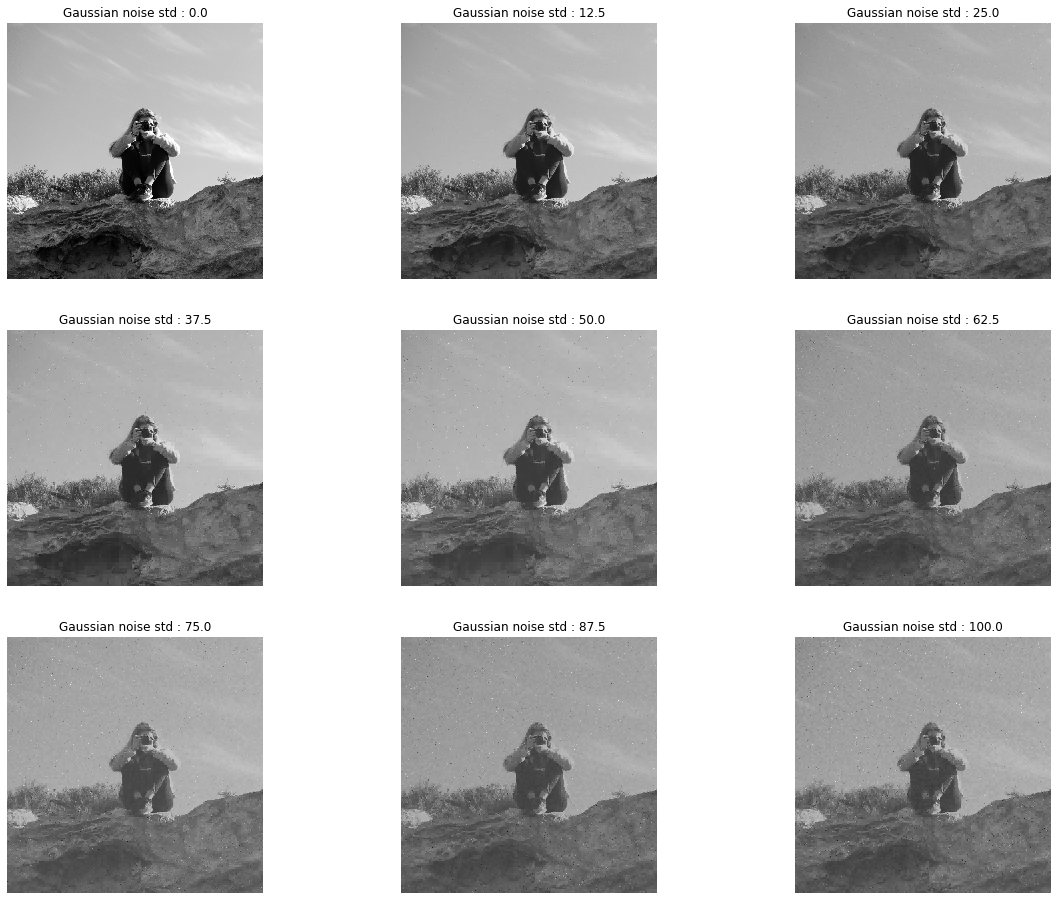

In [8]:
Gaussian_DWT_donoho = []


for i in range(len(Std)):
    print("current image: ",i)
    gaussian_ = Noisy_gauss[i]
    gaussian_ = gaussian_.astype('float64')
    mini = np.inf
    for scale in range(1,6):  #Higher scale are deterioring the image
        transform = twoDDWT(gaussian_,scale)
        typ = "hard"   # Found that on this metric, the hard threshold is better. 
        transform_tresh = thresh(transform,scale,typ)
        reconstruct = inverse_twoDDWT(transform_tresh,scale)
        error = mse(reconstruct,img)
        print("    scale:",scale,"and type : ",typ," :",error)

        if error < mini:
            mini = error
            best = reconstruct
            print("        New mini: ",mini, "found for scale:",scale,"and type : ",typ)
        
    Gaussian_DWT_donoho.append(best)

    
pylab.rcParams['figure.figsize'] = (20, 16) 
for i in range(len(Std)):
    show = Gaussian_DWT_donoho[i]
    plt.subplot(3,3,i+1)
    plt.title("Gaussian noise std : "+str(Std[i]))
    plt.axis('off')
    plt.imshow(show,cmap='gray')
plt.savefig("data/Gaussian noise filtered DWT dohono method")

# Errors 

## On the global level

In [10]:
for i in range(len(Std)):
    print(Std[i],mse(Noisy_gaussy_gauss[i],img), mse(Gaussian_gauss[i],img), mse(Gaussian_DWT_donoho[i],img),mse(Gaussian_DWT[i],img))
    

0.0 0.0 1.681206464767456 0.8188061714172364 17.115105390548706
12.5 9.383784532546997 3.5189499855041504 3.893317587673664 3.7147969976067543
25.0 18.957965850830078 4.753331422805786 5.214466854929924 5.193146824836731
37.5 27.89564871788025 5.875993490219116 6.427681651432071 6.382084421813488
50.0 35.968485593795776 7.229536056518555 7.978998827748011 7.794767437502743
62.5 43.3004686832428 9.162943840026855 10.081678796559572 9.734189121052623
75.0 49.959070920944214 11.605323791503906 12.605592746287586 12.250396326184273
87.5 55.989479541778564 14.324544668197632 15.340801499783993 14.993523046374321
100.0 61.38669228553772 17.115105390548706 18.05293478257954 17.729138243943453


## On the sky

In [11]:
for i in range(len(Std)):
    print(Std[i],mse(Noisy_gauss[i][:500,:500],img[:500,:500]), mse(Gaussian_gauss[i][:500,:500],img[:500,:500]), mse(Gaussian_DWT_donoho[i][:500,:500],img[:500,:500]),mse(Gaussian_DWT[i][:500,:500],img[:500,:500]))
    

0.0 0.0 1.03632 0.9463020000000002 10.134716
12.5 9.473352 2.963884 1.691200625 1.9002206249999998
25.0 19.432416 3.111524 2.230732843749999 2.477494437499999
37.5 29.19406 3.140604 2.4028138359375 2.419395687499997
50.0 38.386428 3.968888 3.2670232890625 3.473090624999999
62.5 46.646792 5.046856 4.875794218749999 3.9417668124999974
75.0 53.947376 6.52392 6.538427937500003 5.791169406250003
87.5 60.581088 8.424508 8.548422687500004 7.5846397812500035
100.0 66.26264 10.134716 10.459315406250008 9.513458937500008
